In [ ]:
# COMPAS - Algoritmerevisjon

### a) - Oversikt over data

C:\Users\leand\AppData\Local\Temp\ipykernel_12896\1407254792.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new["is_recid"] = df_new["is_recid"].map(str)


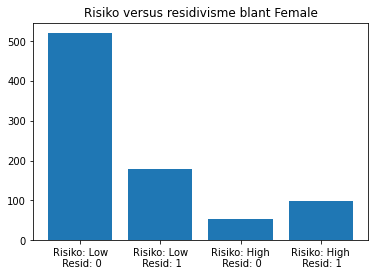

9.25 % av Female som ikke residiverte ble kategorisert som høyrisiko
35.38 % av Female som residiverte ble kategorisert som høyrisiko


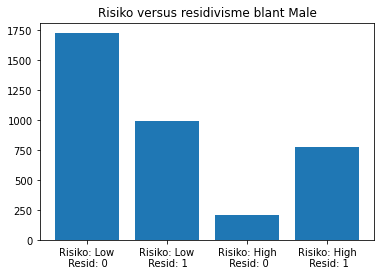

11.02 % av Male som ikke residiverte ble kategorisert som høyrisiko
43.94 % av Male som residiverte ble kategorisert som høyrisiko


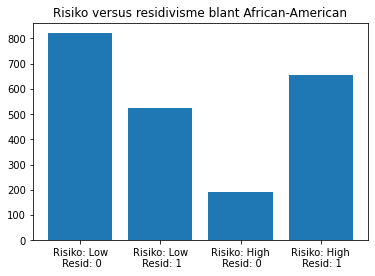

18.79 % av African-American som ikke residiverte ble kategorisert som høyrisiko
55.51 % av African-American som residiverte ble kategorisert som høyrisiko


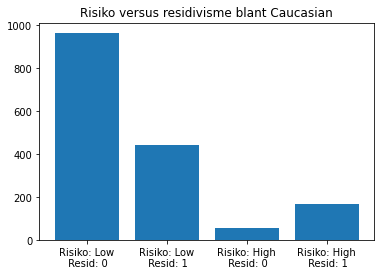

5.5 % av Caucasian som ikke residiverte ble kategorisert som høyrisiko
27.33 % av Caucasian som residiverte ble kategorisert som høyrisiko


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data.csv", delimiter=",")
df = df.dropna(subset=["age"])
df = df[df["days_b_screening_arrest"] <= 30]
df = df[df["days_b_screening_arrest"] >= -30]


for pair in [["sex", "Female"], ["sex", "Male"], ["race", "African-American"], ["race", "Caucasian"]]:
    df_new = df[df[pair[0]].str.contains(pair[1])]
    df_new["is_recid"] = df_new["is_recid"].map(str)

    cat = []
    risk_recid = []
    for i in ["Low", "High"]:
        for j in (0,1):
            A1 = df_new[df_new["score_text"].str.contains(i)]
            A2 = A1[A1["is_recid"].str.contains(f"{j}")]
            risk_recid.append(f"Risiko: {i}\n Resid: {j}")
            cat.append(len(A2))

    plt.bar(risk_recid, cat)
    plt.title(f"Risiko versus residivisme blant {pair[1]}")
    plt.show()
    
    print(f"{round(cat[2]/(cat[0] + cat[2])*100, 2)} % av {pair[1]} som ikke residiverte ble kategorisert som høyrisiko")
    print(f"{round(cat[3]/(cat[1] + cat[3])*100, 2)} % av {pair[1]} som residiverte ble kategorisert som høyrisiko")

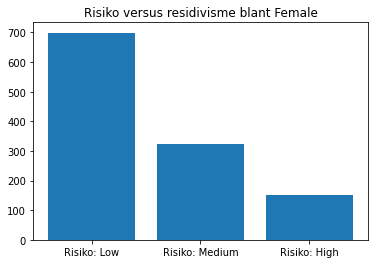

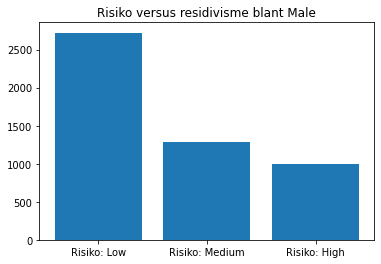

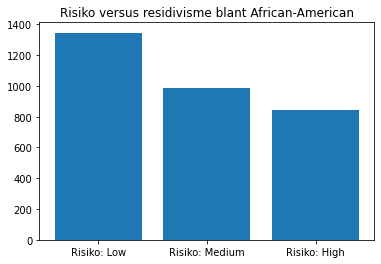

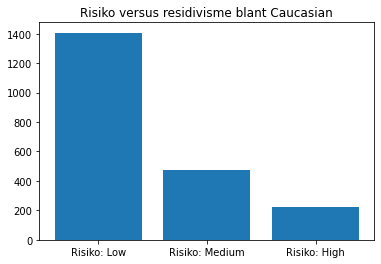

In [4]:
for pair in [["sex", "Female"], ["sex", "Male"], ["race", "African-American"], ["race", "Caucasian"]]:
    df_rec = df[df[pair[0]].str.contains(pair[1])]

    cat = []
    risk_recid = []
    for i in ["Low", "Medium", "High"]:
        for j in (0,1):
            A1 = df_rec[df_rec["score_text"].str.contains(i)]
            risk_recid.append(f"Risiko: {i}")
            cat.append(len(A1))

    plt.bar(risk_recid, cat)
    plt.title(f"Risiko versus residivisme blant {pair[1]}")
    plt.show()

### b) - Sanne/Falske Positive/Negative

In [5]:
for pair in [["sex", "Female"], ["sex", "Male"], ["race", "African-American"], ["race", "Caucasian"]]:
    df_pn = df[df[pair[0]].str.contains(pair[1])]
    df_pn["two_year_recid"] = df_pn["two_year_recid"].map(str)

    high_rec = 0
    high_norec = 0
    low_rec = 0
    low_norec = 0

    
    for num, i in enumerate(["Low", "Medium", "High"]):
        for j in (0,1):
            A1 = df_pn[df_pn["score_text"].str.contains(i)]
            A2 = A1[A1["two_year_recid"].str.contains(f"{j}")]
            if num > 0:
                if j == 0:
                    high_norec += len(A2)
                else:
                    high_rec += len(A2)

            else:
                if j == 0:
                    low_norec += len(A2)
                else:
                    low_rec += len(A2)
    print(f"For gruppen {pair[1]}")
    print("----------------------------")
    print(f"Sanne positive: {high_rec}")
    print(f"Sanne negative: {low_norec}")
    print(f"Falske positive: {high_norec}")
    print(f"Falske negative: {low_rec}")
    print("")
    print(f"Positiv prediktiv verdi: {round(high_rec/(high_rec + high_norec), 3)}")
    print("")
    print("###########################################")
    print("")


C:\Users\leand\AppData\Local\Temp\ipykernel_12896\3935065864.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pn["two_year_recid"] = df_pn["two_year_recid"].map(str)


For gruppen Female
----------------------------
Sanne positive: 246
Sanne negative: 532
Falske positive: 230
Falske negative: 167

Positiv prediktiv verdi: 0.517

###########################################

For gruppen Male
----------------------------
Sanne positive: 1487
Sanne negative: 1813
Falske positive: 788
Falske negative: 909

Positiv prediktiv verdi: 0.654

###########################################

For gruppen African-American
----------------------------
Sanne positive: 1188
Sanne negative: 873
Falske positive: 641
Falske negative: 473

Positiv prediktiv verdi: 0.65

###########################################

For gruppen Caucasian
----------------------------
Sanne positive: 414
Sanne negative: 999
Falske positive: 282
Falske negative: 408

Positiv prediktiv verdi: 0.595

###########################################



### d) - Logistisk regresjon

In [27]:
import sklearn.linear_model as skl
import sklearn.model_selection as ms
import numpy as np


"""
categorical_columns = ["sex", "age_cat", "race"]

for i in categorical_columns:
    dfoh = pd.get_dummies(df[i], prefix=i)
    df = df.drop(i, axis = 1)
    df = df.join(dfoh)


X = df[["sex_Male", "sex_Female", "age_cat_Less than 25", "age_cat_25 - 45", "age_cat_Greater than 45", "race_Other", "race_African-American", "race_Caucasian", "race_Hispanic", "juv_fel_count", "juv_misd_count", "priors_count"]]
Y = df["decile_score"]
"""

X = df[["age_cat", "race", "sex", "priors_count", "c_charge_degree", "two_year_recid"]]
categorical_cols = ["age_cat", "race", "sex", "c_charge_degree"]
X = pd.get_dummies(X, columns=categorical_cols, prefix=categorical_cols, prefix_sep='_')
X = X.drop(["age_cat_25 - 45", "race_Caucasian", "sex_Male", "c_charge_degree_F"], axis=1)
Y = df["score_text"] != "Low"


x_train, x_test, y_train, y_test = ms.train_test_split(X, Y)
model = skl.LogisticRegression(max_iter = 1000)
model.fit(X, Y)

LogisticRegression(max_iter=1000)

Kategori: priors_count, bias: [1.2395849]
Kategori: two_year_recid, bias: [1.6846462]
Kategori: age_cat_Greater than 45, bias: [0.30018164]
Kategori: age_cat_Less than 25, bias: [2.48513611]
Kategori: race_African-American, bias: [1.45308445]
Kategori: race_Asian, bias: [0.84041395]
Kategori: race_Hispanic, bias: [0.69919876]
Kategori: race_Native American, bias: [1.94461974]
Kategori: race_Other, bias: [0.49577198]
Kategori: sex_Female, bias: [1.19240101]
Kategori: c_charge_degree_M, bias: [0.77026261]


<BarContainer object of 11 artists>

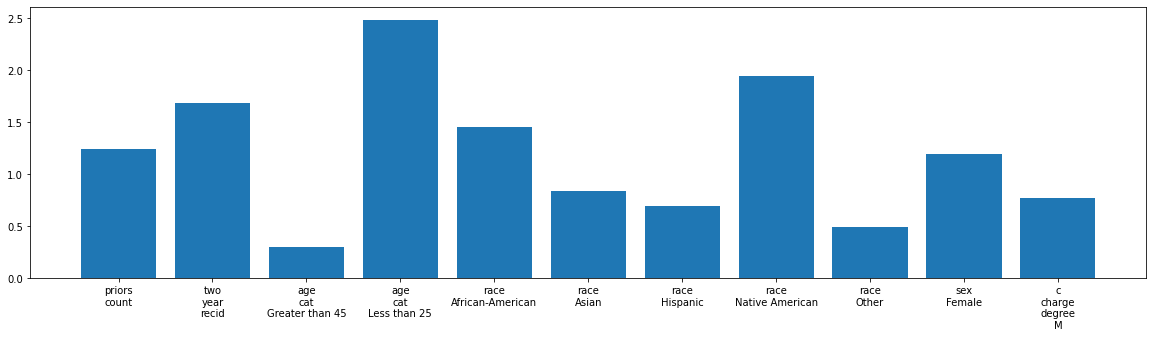

In [49]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x_hist = []
y_hist = []

for i in range(len(X.columns)):
    
    b = model.intercept_
    w = model.coef_[0][i]

    control = sigmoid(b)
    bias = np.exp(w) / (1 - control + (control * np.exp(w)))
    
    s = X.columns[i].split("_")
    ret = ""
    for word in s:
        ret = ret + f"{word}\n"
    x_hist.append(ret)
    y_hist.append(bias[0])
    
    print(f"Kategori: {X.columns[i]}, bias: {bias}")
    
plt.figure(figsize=(20, 5))
plt.bar(x_hist, y_hist)
